In [8]:
from neuron import h
from neuron.units import mV, ms, um
import numpy as np
import plotly
from pprint import pprint
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import LFPy
import MEAutility as mu
from matplotlib.collections import LineCollection
from pathlib import Path
import MEArec as mr
import pwlf
import sympy
import csv
import lfpykit

In [9]:
h.load_file("stdrun.hoc")

1.0

In [10]:
%run ZIAD_MEARecHelperFunctions.ipynb

In [11]:
def calc_B_field(cell, electrode):
    print("Calculating Magnetic Field")
    i_axial, d_vectors, pos_vectors = cell.get_axial_currents_from_vmem()
    i_axial = i_axial * 1e-9 #Convert to nA
    d_vectors = d_vectors * 1e-6 #Convert to um
    pos_vectors = pos_vectors * 1e-6 #Convert to um

    # print("Imem: ", cell.imem)
    # print("Iaxial: ", i_axial)
    # print("Imem shape: ", np.shape(cell.imem))
    # print("Iaxial shape: ", np.shape(i_axial))
    #print("CDP: ", current_dipole_moment)
    #print("CDP shape: ", np.shape(current_dipole_moment))

    #print("I_axial: ", i_axial)
    #print("D_vectors: ", d_vectors)
    #print("Pos_vectors: ", pos_vectors)

    num_elecs = len(electrode.x)
    time_len = len(cell.tvec)
    dims = 3
    all_B_fields = np.zeros((num_elecs, dims, time_len))

    for i in range(len(electrode.x)):
        R = np.array([electrode.x[i], electrode.y[i], electrode.z[i]])
        R = R * 1e-6 #Convert to um
        #print(R)
        B = calc_B_field_single_sensor(cell, R, i_axial, d_vectors, pos_vectors)
        all_B_fields[i] = B

    return all_B_fields

def calc_B_field_single_sensor(cell, R, i_axial, d_vectors, pos_vectors):
    B = np.zeros((3, cell.tvec.size))

    count = 0
    r_rel = R - pos_vectors
    cross = np.cross(d_vectors.T, r_rel)
    divisor = 1e7 * np.sqrt((r_rel**2).sum(axis=1))**3
    vec = cross / np.expand_dims(divisor, axis=0).T

    count = 0
    for ax_curr in i_axial.T:
        B[:, count] = ax_curr @ vec
        count += 1

    return B

def taper_axon(axon, nseg, start_diam, end_diam, hillock=True, hillock_length=20, hillock_mult=5):
    diams = np.arange(end_diam, start_diam+0.001, (start_diam-end_diam)/(nseg-1))
    
    if hillock:
        num_diams = round(hillock_length/ (axon.L / nseg))
        hill_diams = np.linspace(start_diam, hillock_mult*start_diam, num_diams)
        new_diams = np.arange(end_diam, start_diam+0.001, (start_diam-end_diam)/(nseg-len(hill_diams)))
        diams[-1*len(hill_diams):] = hill_diams
        diams[:len(new_diams)] = new_diams
        
    diams = np.flip(diams) 
    
    for i, seg in enumerate(axon.allseg()):
        if i > 0 and i < nseg+1:
            seg.diam = diams[i-1]
            
def get_M(cell, x, y, z, sigma):
    """Loop over electrode contacts, and return LFPs across channels"""
    M = np.zeros((x.size, cell.x.shape[0]))
    r_limit = cell.d / 2
    for i in range(x.size):
        M[i, :] = lfpykit.lfpcalc.calc_lfp_linesource(cell = cell,
                                  x=x[i],
                                  y=y[i],
                                  z=z[i],
                                  sigma=sigma,
                                  r_limit=r_limit)
    return M

### Initialize Cell

In [12]:
T = 50
dt = 0.03125
v_init = -65
radial_scaling = True
# Radial Scaling
dist_along_axon = 10

# Axial scaling
dist_from_axon = 50

cell_name = 'L5_TTPC1_cADpyr232_1'
mea_cells_folder = '/Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/'
cell_model_folder = Path(Path(mea_cells_folder) / cell_name)
cell = mr.return_bbp_cell(cell_model_folder, 
                          end_T = T, 
                          dt = dt, 
                          start_T = 0)

# Radial scaling
if radial_scaling == True:
    cell.set_rotation(np.pi, -np.pi/2, np.pi, 'zyx')
    cell.set_pos(-10, -1*dist_along_axon, -500)

# Axial scaling
else:
    cell.set_rotation(np.pi+np.pi/50, -np.pi/2, np.pi, 'zyx')
    cell.set_pos(-10, -500, -1*dist_from_axon)
    
cell._update_pt3d()

Mechanisms already loaded from path: /Users/Ziad/.config/mearec/1.7.2/cell_models/MEArecLinearCells/mods.  Aborting.
template cADpyr232_L5_TTPC1_0fb1ca4724 exist already
Morphology:  morphology/dend-C060114A2_axon-C060114A5.asc
Type:  <class 'str'>
Morphology is a string


In [13]:
np.shape(cell.d)

(1325,)

In [14]:
count = 0
for sec in cell.allseclist:
    print(sec)
    count += sec.nseg
        
print(count)

cADpyr232_L5_TTPC1_0fb1ca4724[1].soma[0]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[0]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[1]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[2]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[3]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[4]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[5]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[6]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[7]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[8]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[9]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[10]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[11]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[12]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[13]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[14]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[15]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[16]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[17]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[18]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[19]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[20]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[21]
cADpyr232_L5_TTPC1_0fb1ca4724[1].dend[22]
cAD

In [15]:
sec.nseg

1

In [16]:
for i in range(sec.n3d()):
    print(sec.x3d(i), sec.y3d(i), sec.z3d(i))

-10.0 34.21123123168945 -505.1693420410156
-10.0 49.10973358154297 -506.91131591796875
-10.0 64.00823974609375 -508.6533203125


In [17]:
dir(cell)

['Ra',
 '_Cell__calc_totnsegs',
 '_Cell__check_currents',
 '_Cell__collect_tvec',
 '_Cell__collect_vstim',
 '_Cell__get_idx',
 '_Cell__purge_hoc_pointprocesses',
 '_Cell__run_custom_codes',
 '_Cell__run_simulation',
 '_Cell__set_current_dipole_moment_array',
 '_Cell__set_extracellular',
 '_Cell__set_ipointprocess_recorders',
 '_Cell__set_isyn_recorders',
 '_Cell__set_negs',
 '_Cell__set_nsegs_fixed_length',
 '_Cell__set_nsegs_lambda100',
 '_Cell__set_nsegs_lambda_f',
 '_Cell__set_passive',
 '_Cell__set_ra_and_cm',
 '_Cell__set_time_recorders',
 '_Cell__set_vpointprocess_recorders',
 '_Cell__set_vsyn_recorders',
 '_Cell__update_synapse_positions',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',


In [18]:
M = get_M(cell, x, y, z, 0.3)

NameError: name 'x' is not defined

In [61]:
np.shape(M)

(20, 1325)

In [19]:
for i in sec.allseg():
    print(i)

cADpyr232_L5_TTPC1_0fb1ca4724[1].axon[1](0)
cADpyr232_L5_TTPC1_0fb1ca4724[1].axon[1](0.5)
cADpyr232_L5_TTPC1_0fb1ca4724[1].axon[1](1)


### Connect stimulus to cell

In [20]:
for sec in cell.allseclist:
    if 'soma' in str(sec):
        print(sec)
        break
        
soma = sec

# Create synapse
syn = h.IClamp(0.5, sec=soma)
syn.dur = 60
syn.delay = 5

# Create vector to "play" stimulus into cell - can be time-varying if desired
weight = 0.75
tot_ntsteps = int(round(T / dt + 1))
I = np.ones(tot_ntsteps) * weight
#I[400:1000] = 0
noiseVec = h.Vector(I)

noiseVec.play(syn._ref_amp, dt)

cADpyr232_L5_TTPC1_0fb1ca4724[1].soma[0]


Vector[9254]

### Recording Gating Variables

In [21]:
# stateVars = {}
# for var in ['m', 'h', 'n']:
#     stateVars[var] = h.Vector()
# stateVars['m'].record(soma(0.5).hh._ref_m, sec=soma)
# stateVars['h'].record(soma(0.5).hh._ref_h, sec=soma)
# stateVars['n'].record(soma(0.5).hh._ref_n, sec=soma)

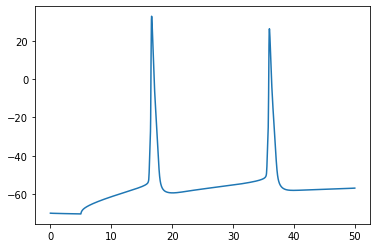

In [22]:
cell.simulate(rec_imem=True, rec_vmem=True)
t = np.arange(0, T+dt, dt)

#plt.plot(np.arange(0, T+dt, dt), cell.somav)
plt.plot(t, cell.vmem[0])

### Calculate Extracellular V

In [23]:
if radial_scaling == True:
    mea_name = '1000MEA1'
else:
    mea_name = '1000MEA1_Axial'
    
mea = mu.return_mea(mea_name)
electrodes = LFPy.RecExtElectrode(cell, probe=mea)

lfp = electrodes.get_transformation_matrix() @ cell.imem

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_11093/3864615857.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(X, Y, '.', marker='o', markersize=3, color='k', zorder=0)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_11093/3864615857.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([lim, lim, -lim, -lim], [lim, -lim, lim, -lim], '.', marker='o', markersize=1, color='blue')
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_11093/3864615857.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot([lim, lim, -lim, -lim], [lim, -lim, lim, -lim], '.', marker='o', markersize=1, color='blue')


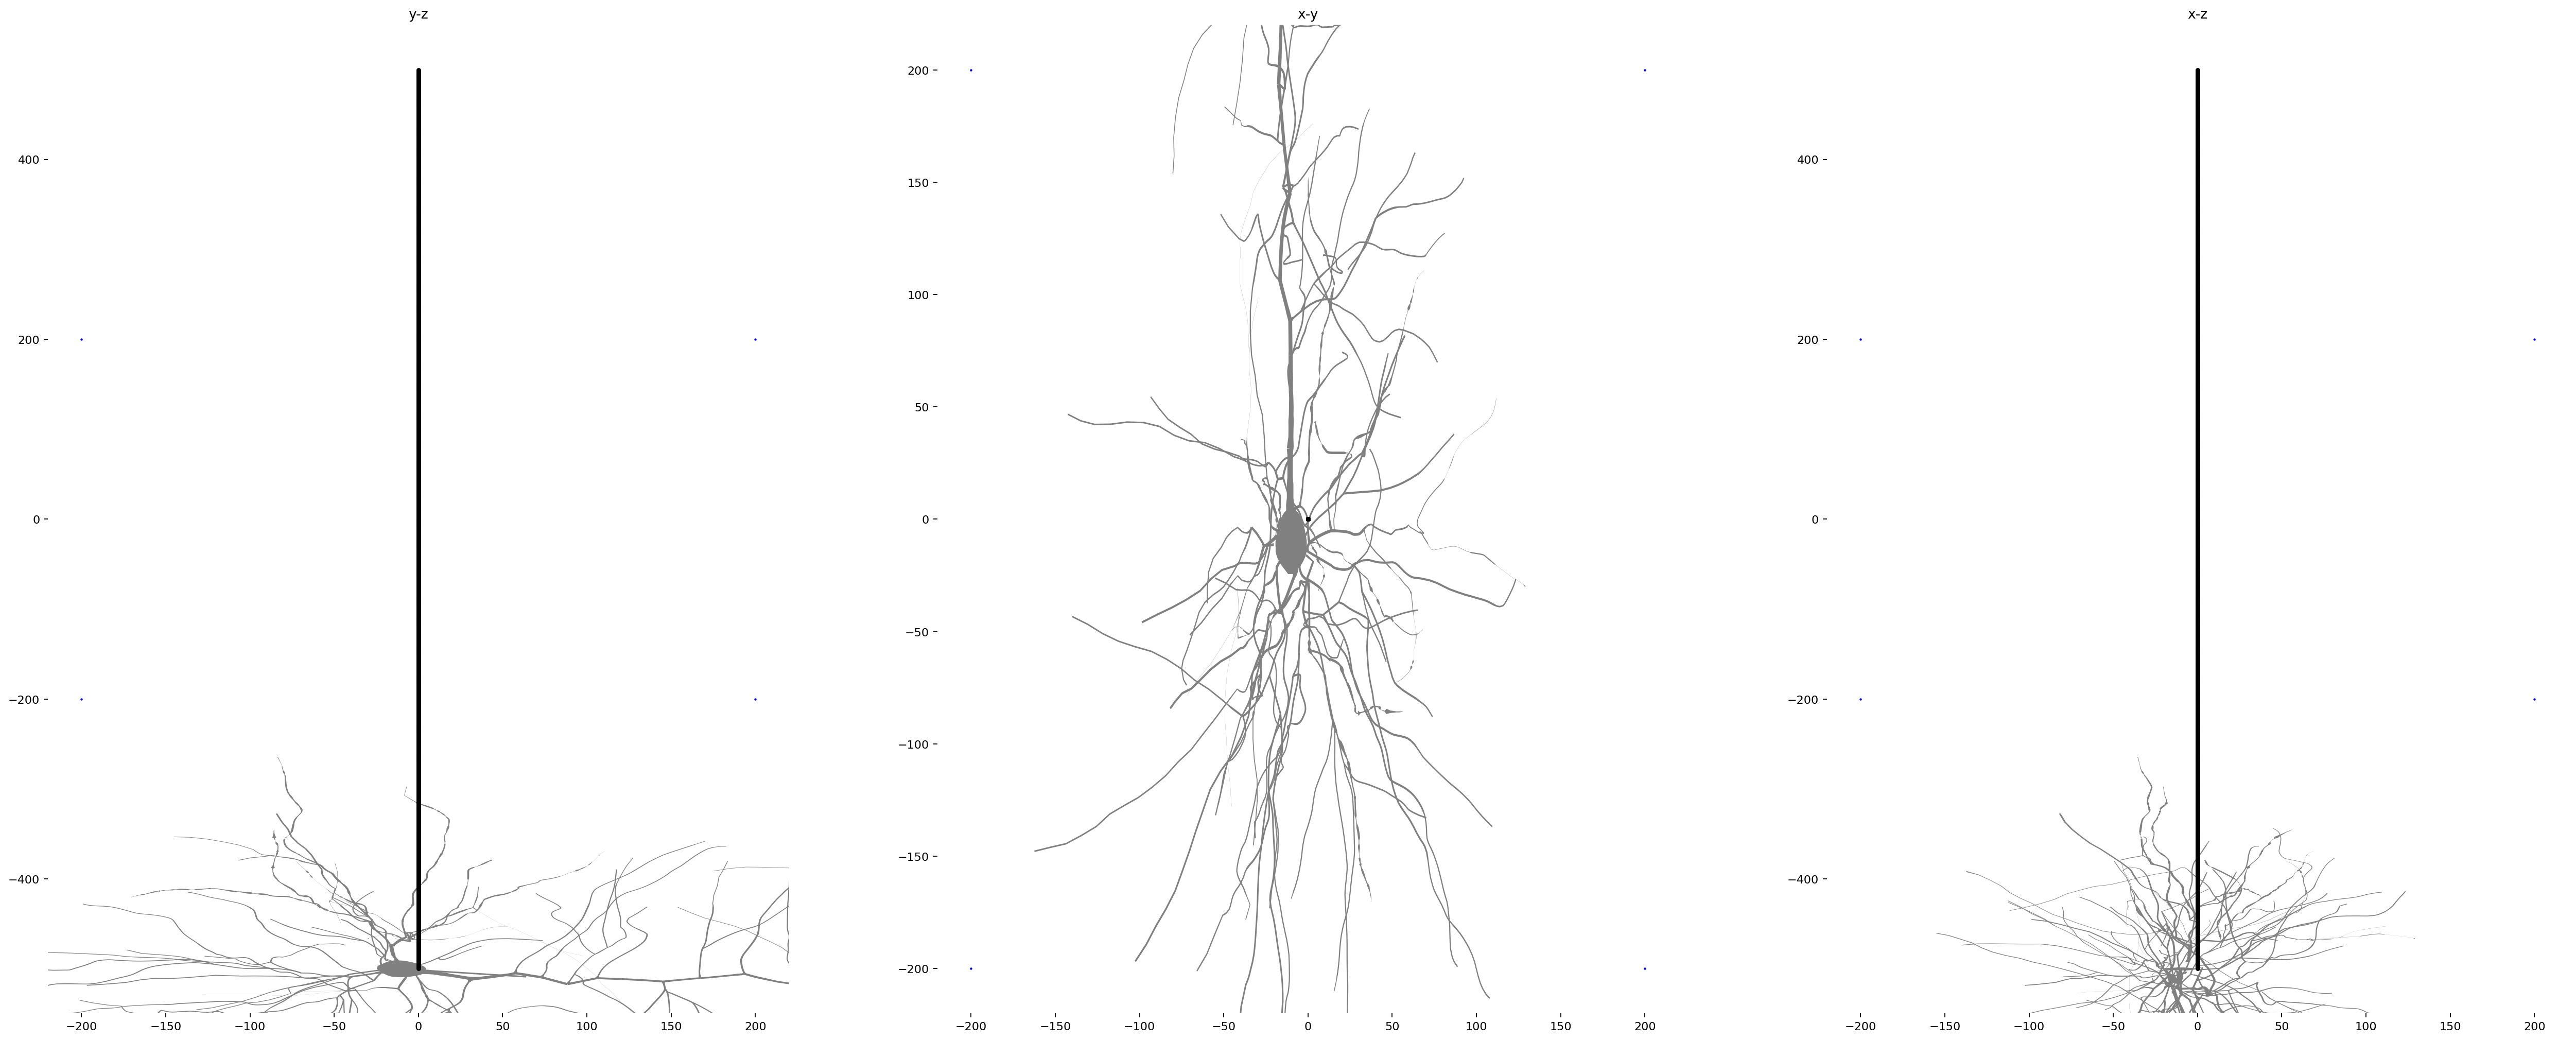

In [24]:
mea = mu.return_mea(mea_name)
electrodes = LFPy.RecExtElectrode(cell, probe=mea)

#cell.set_pos(0, 0, 0)
#cell.set_rotation(0, 0, -0.05)
#cell.set_rotation(0, 1.5, -0.05)
fig = plotcell_3planes(cell, electrodes, 200, plot_electrodes=True)

In [40]:
with open('test_vmem.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    data = ['x1', 'x2', 'y1', 'y2', 'z1', 'z2']
    data = list(data) + list(np.arange(len(cell.vmem[0][800:])))
    
    writer.writerow(data)
    
    data = [cell.x[0, 0], cell.x[0, 1], cell.y[0, 0], cell.y[0, 1], cell.z[0, 0], cell.z[0, 1]]
    data = list(data) + list(cell.vmem[0][800:])
    
    writer.writerow(data)

In [39]:
len(cell.vmem[0][700:])

901

### Calculate Magnetic Data

In [25]:
all_B = calc_B_field(cell, electrodes)

Calculating Magnetic Field
Pos shape old:  (2648, 3)


In [26]:
# Extract spike
def get_spike_data(sig, elec=False, basic=False, ret_points=False):
    if basic == True:
        return abs(np.max(sig) - np.min(sig))
        
    sig = sig - sig[0]
    spike_max_idx = np.argmax(sig)
    spike_min_idx = np.argmin(sig)
    
    if spike_max_idx > spike_min_idx or elec==True:
        first_idx = spike_min_idx
        second_idx = np.argmax(sig[first_idx:])+first_idx
    else:
        first_idx = spike_max_idx
        second_idx = np.argmin(sig[first_idx:])+first_idx
        
    #print(first_idx, second_idx)
    #print(sig[first_idx], sig[second_idx])
    if ret_points:
        return abs(sig[first_idx] - sig[second_idx]), first_idx, second_idx
    
    return abs(sig[first_idx] - sig[second_idx])

In [27]:
# Moving average exponential rate of change calculator
from scipy.stats import linregress

def moving_avg_roc(x, y, taps):
    logy = np.log10(y)
    logx = np.log10(x)
    
    roc = []
    for i in range(taps, len(x)):
        slope, intercept = np.polyfit(logx[i-taps:i], logy[i-taps:i], 1)
        roc.append(1/(slope))
        
    roc = np.array(roc)
    
    return roc

def moving_avg(y, taps):
    
    avg_y = []
    for i in range(taps, len(y)):
        avg_y.append(np.mean(y[i-taps:i]))
        
    return avg_y

In [29]:
taps = 50
data_max = get_spike_data(all_B)
avg_data = moving_avg(data_max, taps)

ValueError: attempt to get argmax of an empty sequence

In [21]:
logavg = np.log10(avg_data)

In [22]:
rocavg = (logavg[1:] - logavg[:-1])/(logr[int(taps/2)+1:-int(taps/2)] - logr[int(taps/2):-int(taps/2+1)])

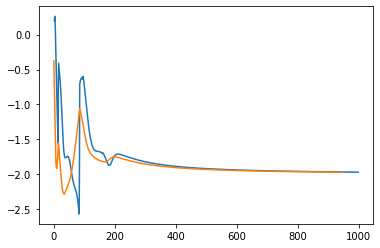

In [23]:
plt.plot(roc)
plt.plot(rocavg)

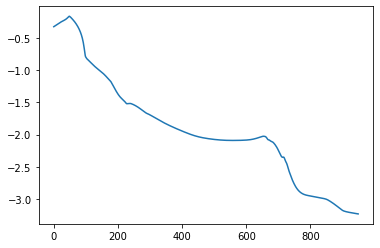

In [26]:
plt.plot(logavg)

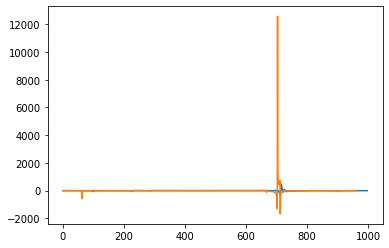

In [27]:
maroc = moving_avg_roc(data_max, r, 2)
plt.plot(maroc)
maroc = moving_avg_roc(data_max, r, 40)
plt.plot(maroc)

In [30]:
maroc

array([        nan,         nan,  5.14972454,  3.7959032 ,  4.44062905,
       12.85027662, -7.98359944, -2.98609584, -1.87522261, -1.42082173,
       -1.13789673, -0.95076697, -0.81810783, -0.71811137, -0.63919025,
       -1.55930169, -2.44480825, -2.1794276 , -1.96202112, -1.78087415,
       -1.62593635, -1.48289057, -1.35259491, -1.23308899, -1.1236141 ,
       -1.0240049 , -0.9343972 , -0.85509232, -0.78643684, -0.72865228,
       -0.68164078, -0.64484721, -0.61724531, -0.59745554, -0.58394239,
       -0.57551553, -0.57095715, -0.56825976, -0.56719454, -0.56720019,
       -0.56788406, -0.5689634 , -0.57040147, -0.57256173, -0.57352196,
       -0.5739998 , -0.57377093, -0.57264192, -0.57047527, -0.56720393,
       -0.56308161, -0.55883294, -0.55261794, -0.54566561, -0.5381732 ,
       -0.5303541 , -0.52241843, -0.51564881, -0.50863939, -0.50137449,
       -0.49450619, -0.48808565, -0.48257297, -0.47847791, -0.47361816,
       -0.46928075, -0.4654237 , -0.46215943, -0.46049093, -0.45

In [39]:
print(np.polyfit(logr[2:4], logdata[2:4], 1))

[ 0.19418514 -0.13807455]


In [38]:
1/((logdata[3] - logdata[2])/(logr[3] - logr[2]))

5.149724540939477

In [31]:
roc

array([        nan,         nan,  0.19418514,  0.26344191,  0.22519332,
        0.07781934, -0.12525679, -0.33488543, -0.53327002, -0.70381806,
       -0.87881437, -1.05178243, -1.22233276, -1.39254166, -1.56447944,
       -0.64131271, -0.40903003, -0.45883607, -0.50967851, -0.56152199,
       -0.61503023, -0.6743586 , -0.73931965, -0.81097148, -0.88998527,
       -0.97655783, -1.07020869, -1.16946437, -1.27155792, -1.37239673,
       -1.46704837, -1.55075494, -1.62010141, -1.67376471, -1.71249771,
       -1.73757256, -1.75144491, -1.75975861, -1.76306352, -1.76304597,
       -1.76092283, -1.75758229, -1.75315117, -1.74653658, -1.74361239,
       -1.74216088, -1.74285581, -1.74629199, -1.75292437, -1.76303433,
       -1.7759415 , -1.78944356, -1.80956846, -1.83262421, -1.85813786,
       -1.88553269, -1.91417444, -1.9393044 , -1.96602943, -1.99451713,
       -2.02221937, -2.04882072, -2.07222549, -2.08996066, -2.1114055 ,
       -2.13092057, -2.1485799 , -2.16375547, -2.17159542, -2.18

### Calculate Scaling

/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_11093/1680091685.py:32: RuntimeWarning: invalid value encountered in log10
  logr = np.log10(r)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_11093/1680091685.py:32: RuntimeWarning: invalid value encountered in log10
  logr = np.log10(r)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_11093/1680091685.py:32: RuntimeWarning: invalid value encountered in log10
  logr = np.log10(r)
/var/folders/df/rk7rf_5s4253kn_8sb19p5x80000gn/T/ipykernel_11093/1680091685.py:32: RuntimeWarning: invalid value encountered in log10
  logr = np.log10(r)


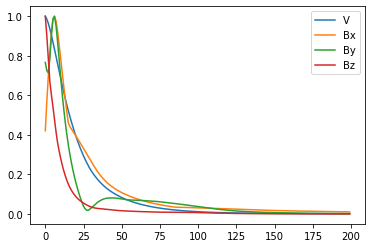

In [30]:
start_idx = 500
end_idx = 650
idxs = slice(start_idx,end_idx)

for i in [-1, 0, 1, 2]:
    if i == -1:
        data = np.copy(lfp[:, idxs])
    else:
        data = np.copy(all_B[:, i, idxs])

    #for n in range(len(data)):
    #    data[n] = data[n] - data[n, 0]

    #data_max = np.max(abs(data), axis=1)
    #data_max = np.max(data, axis=1) - np.min(data, axis=1)
    data_max = []
    for n in range(len(data)):
        if radial_scaling:
            sig_pp = get_spike_data(np.copy(data[n]), elec=i==-1)
        else:
            sig_pp = get_spike_data(np.copy(data[n]), basic=True)
        #print(sig_pp)
        data_max.append(sig_pp)
    
    data_max = np.array(data_max)
    data_max = data_max / max(data_max)
    logdata = np.log10(data_max)
    if radial_scaling:
        r = electrodes.z - cell.z3d[0][0]
    else:
        r = electrodes.y - cell.y3d[0][0]
    logr = np.log10(r)
    roc = (logdata[1:] - logdata[:-1])/(logr[1:] - logr[:-1])
    plt.plot(data_max[:200])

plt.legend(['V', 'Bx', 'By', 'Bz'])

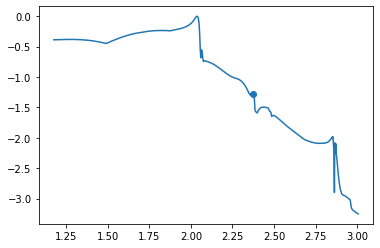

In [16]:
plt.plot(logr, logdata)

idx = 220
plt.scatter(logr[idx], logdata[idx])

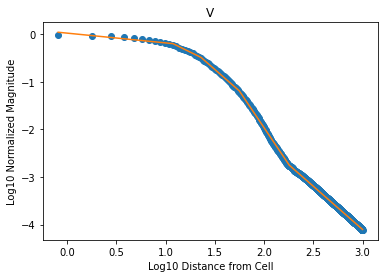

In [88]:
x = logr[2:]
y = logdata[2:]
my_pwlf = pwlf.PiecewiseLinFit(x, y)
#res = my_pwlf.fit(5)

x0 = np.array([2, 13, 24, 57, 180, -1])
x0 = logr[x0]
res = my_pwlf.fit_with_breaks(x0)

xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

plt.figure()
plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')
plt.title('V')
plt.ylabel('Log10 Normalized Magnitude')
plt.xlabel('Log10 Distance from Cell')
plt.show()

In [35]:
dir(my_pwlf)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fit_one_segment',
 '_get_breaks',
 '_switch_to_np_array',
 'assemble_regression_matrix',
 'beta',
 'break_0',
 'break_n',
 'c_n',
 'calc_slopes',
 'conlstsq',
 'degree',
 'fit',
 'fit_breaks',
 'fit_force_points_opt',
 'fit_guess',
 'fit_with_breaks',
 'fit_with_breaks_force_points',
 'fit_with_breaks_opt',
 'fitfast',
 'intercepts',
 'lapack_driver',
 'lstsq',
 'nVar',
 'n_data',
 'n_parameters',
 'n_segments',
 'p_values',
 'predict',
 'prediction_variance',
 'print',
 'r_squared',
 'se',
 'seed',
 'slopes',
 'ssr',
 'standard_errors',
 'use_custom_opt',
 'weights',
 'x_c',
 'x_data',
 'y_c',
 'y_data',
 'y_w',
 'zeta

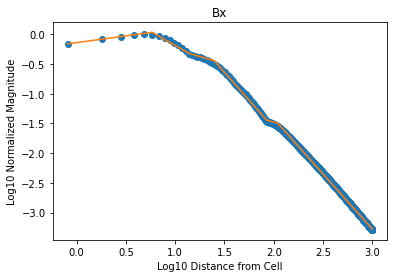

In [78]:
x = logr[2:]
y = logdata[2:]
my_pwlf = pwlf.PiecewiseLinFit(x, y)

x0 = np.array([2, 7, 15, 26, 86, 111, -1])
x0 = logr[x0]
res = my_pwlf.fit_with_breaks(x0)

xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

plt.figure()
plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')
plt.title('Bx')
plt.ylabel('Log10 Normalized Magnitude')
plt.xlabel('Log10 Distance from Cell')
plt.show()

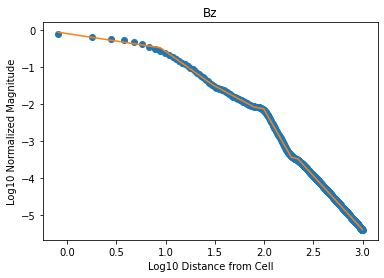

In [39]:
x = logr[2:]
y = logdata[2:]
my_pwlf = pwlf.PiecewiseLinFit(x, y)

x0 = np.array([2, 10, 31, 80, 100, 190, 220, -1])
x0 = logr[x0]
res = my_pwlf.fit_with_breaks(x0)

xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

plt.figure()
plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')
plt.title('Bz')
plt.ylabel('Log10 Normalized Magnitude')
plt.xlabel('Log10 Distance from Cell')
plt.show()

In [95]:
#x0 = np.array([2, 13, 24, 57, 180, -1])

yidxs = slice(57, 181)

for val in logdata[180:]:
    print(val)

-2.7723565983265783
-2.775686631031315
-2.775599011628638
-2.775969592693811
-2.776801614550531
-2.778093983720334
-2.779841089304272
-2.7820328253355093
-2.7846548209095454
-2.787688859292388
-2.791113448548449
-2.7948663460593846
-2.798915915024444
-2.803288554515785
-2.807955907645998
-2.812889638920187
-2.818061888537524
-2.8234456147163454
-2.829014832961967
-2.8347447689829064
-2.840611945664243
-2.8465942246368834
-2.8526708204343976
-2.858822301056012
-2.8650305839647205
-2.8712453045655693
-2.873718084554105
-2.87618153785044
-2.878641813048242
-2.8811042033558296
-2.883573199050533
-2.8860525442279825
-2.8885452970120555
-2.8910538920805084
-2.8935802041666574
-2.8961256111542544
-2.898691055466629
-2.901277102634952
-2.90388399616909
-2.9065117081160508
-2.9091599849425296
-2.9118283885990577
-2.9145163328080916
-2.9172231147581407
-2.919947942484401
-2.922689958281176
-2.9254482585226587
-2.928221910280146
-2.931009965115448
-2.9338114704131635
-2.936625478584605
-2.9394510

In [89]:
from sympy import Symbol
from sympy.utilities import lambdify
x = Symbol('x')


def get_symbolic_eqn(pwlf_, segment_number):
    if pwlf_.degree < 1:
        raise ValueError('Degree must be at least 1')
    if segment_number < 1 or segment_number > pwlf_.n_segments:
        raise ValueError('segment_number not possible')
    # assemble degree = 1 first
    for line in range(segment_number):
        if line == 0:
            my_eqn = pwlf_.beta[0] + (pwlf_.beta[1])*(x-pwlf_.fit_breaks[0])
        else:
            my_eqn += (pwlf_.beta[line+1])*(x-pwlf_.fit_breaks[line])
    # assemble all other degrees
    if pwlf_.degree > 1:
        for k in range(2, pwlf_.degree + 1):
            for line in range(segment_number):
                beta_index = pwlf_.n_segments*(k-1) + line + 1
                my_eqn += (pwlf_.beta[beta_index])*(x-pwlf_.fit_breaks[line])**k
    return my_eqn.simplify()


eqn_list = []
f_list = []
for i in range(my_pwlf.n_segments):
    eqn_list.append(get_symbolic_eqn(my_pwlf, i + 1))
    print('Equation number: ', i + 1)
    print(eqn_list[-1])
    f_list.append(lambdify(x, eqn_list[-1]))

Equation number:  1
0.0231562159954552 - 0.203458367601282*x
Equation number:  2
0.885867045720173 - 1.00791046266219*x
Equation number:  3
1.96872014339709 - 1.80517322302429*x
Equation number:  4
4.21110124493197 - 3.08891934164975*x
Equation number:  5
1.34632165343292 - 1.81704236950983*x


0.003791575469292767 31 69


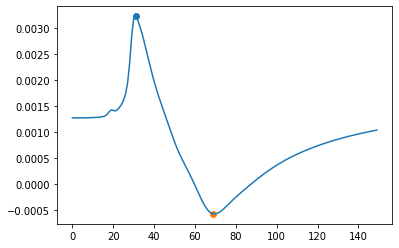

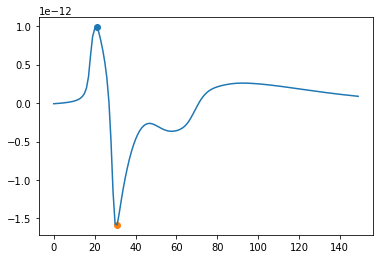

In [14]:
idx = 150
val, idx1, idx2 = get_spike_data(lfp[:, idxs][idx], elec=False, basic=False, ret_points=True)
print(val, idx1, idx2)
plt.plot(lfp[:, idxs][idx])
plt.scatter(idx1, lfp[:, idx1+start_idx][idx])
plt.scatter(idx2, lfp[:, idx2+start_idx][idx])

plt.figure()
val, idx1, idx2 = get_spike_data(all_B[:, 0, idxs][idx], elec=False, basic=False, ret_points=True)
plt.plot(all_B[:, 0, idxs][idx])
plt.scatter(idx1, all_B[:, 0, idx1+start_idx][idx])
plt.scatter(idx2, all_B[:, 0, idx2+start_idx][idx])


In [37]:
idxs

slice(400, 800, None)

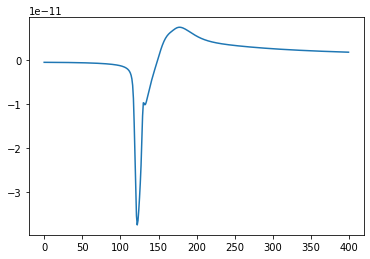

In [37]:
plt.plot(all_B[:, 0, idxs][20])

In [10]:
for sec in cell.allseclist:
    print(sec)

cADpyr232_L5_TTPC1_0fb1ca4724[0].soma[0]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[0]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[1]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[2]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[3]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[4]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[5]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[6]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[7]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[8]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[9]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[10]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[11]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[12]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[13]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[14]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[15]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[16]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[17]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[18]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[19]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[20]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[21]
cADpyr232_L5_TTPC1_0fb1ca4724[0].dend[22]
cAD